In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.stats import norm

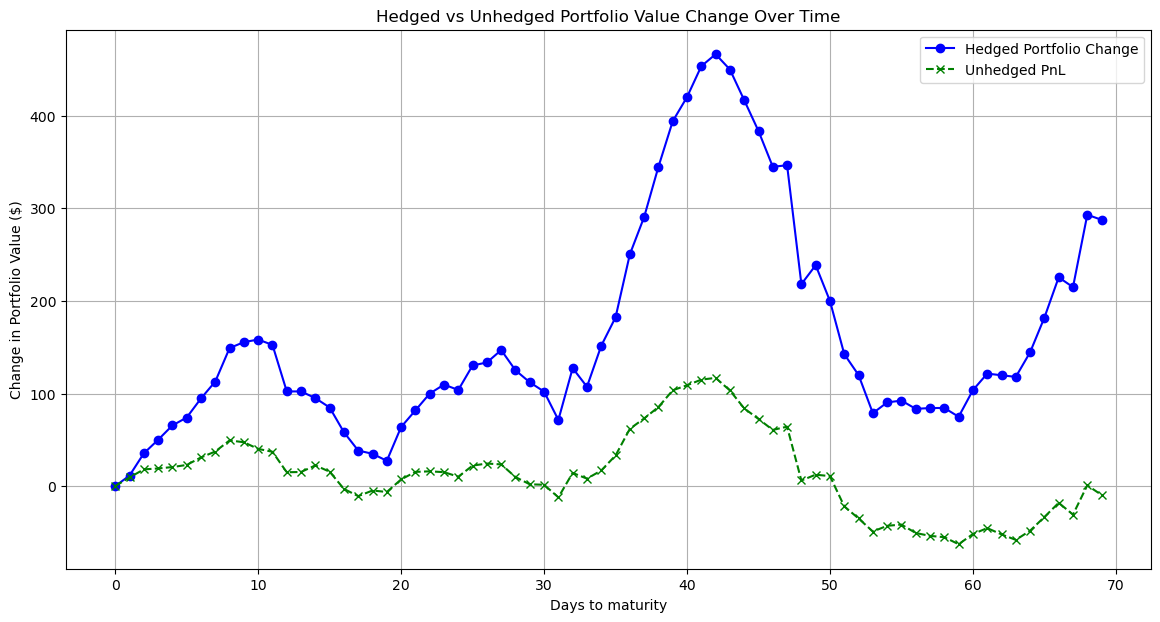

In [94]:
# Load the dataset
df = pd.read_excel('vola_price.xlsx')

# Define the functions for option delta and price
def option_delta(rf, σ, t, K, S):
    d1 = (np.log(S / K) + (rf + σ**2 / 2) * t) / (σ * np.sqrt(t))
    delta = norm.cdf(d1)
    return delta

def option_price(rf, σ, t, K, S):
    d1 = (np.log(S / K) + (rf + σ**2 / 2) * t) / (σ * np.sqrt(t))
    d2 = d1 - σ * np.sqrt(t)
    call_price = S * norm.cdf(d1) - K * np.exp(-rf * t) * norm.cdf(d2)
    return call_price

# Parameters
rf = math.exp(0.0538/261) - 1  # risk-free rate
K = 1900  # strike price

# Calculate time to maturity in years, assuming 365 days per year
df['Days_to_Maturity'] = (df.index[::-1] + 1) / 365

# Calculate the option price and delta for each row
df['Option_Price'] = df.apply(lambda row: option_price(rf, row['volatility'], row['Days_to_Maturity'], K, row['Price']), axis=1)
df['Delta'] = df.apply(lambda row: option_delta(rf, row['volatility'], row['Days_to_Maturity'], K, row['Price']), axis=1)

# Initialize the portfolio with one unit of gold
portfolio = {'gold': 1, 'options': 0, 'cash': 0}

# The initial price of gold
initial_gold_price = df.iloc[0]['Price']

# Go through each day
for index, row in df.iterrows():
    # Update the portfolio: adjust the number of options to maintain delta neutrality
    gold_delta = portfolio['gold']  # Delta of gold is 1 per unit of gold
    options_to_buy = gold_delta - portfolio['options'] * row['Delta']
    portfolio['options'] += options_to_buy  # Buy or sell options to adjust delta
    portfolio['cash'] -= options_to_buy * row['Option_Price']  # Pay or receive cash for options trade

    # Update the value of gold holdings and add the option value for the day
    portfolio_value = portfolio['gold'] * row['Price'] + portfolio['options'] * row['Option_Price']

    # The portfolio change is the new portfolio value plus cash minus the initial gold price
    portfolio_change = portfolio_value + portfolio['cash'] - initial_gold_price

    # Store the portfolio change
    df.at[index, 'Portfolio_Change'] = portfolio_change

# Calculate the unhedged PnL
df['Unhedged_PnL'] = (df['Price'] - initial_gold_price) * portfolio['gold']

# Plot the hedged and unhedged PnL
plt.figure(figsize=(14, 7))

# Hedged PnL
plt.plot(df.index, -1 * df['Portfolio_Change'], marker='o', linestyle='-', color='b', label='Hedged Portfolio Change')

# Unhedged PnL
plt.plot(df.index, -1 *df['Unhedged_PnL'], marker='x', linestyle='--', color='g', label='Unhedged PnL')

# Titles and labels
plt.title('Hedged vs Unhedged Portfolio Value Change Over Time')
plt.xlabel('Days to maturity')
plt.ylabel('Change in Portfolio Value ($)')
plt.legend()
plt.grid()

# Show the plot
plt.show()